In [4]:
# | default_exp model

%load_ext autoreload
%autoreload 2

%env TOKENIZERS_PARALLELISM=false
%env PYDEVD_DISABLE_FILE_VALIDATION=1

env: TOKENIZERS_PARALLELISM=false
env: PYDEVD_DISABLE_FILE_VALIDATION=1


In [5]:
# | export
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter


from torch.nn import functional as F
from tokenizers import (
    Tokenizer,
)
from tokenizers import ByteLevelBPETokenizer


from datetime import datetime
from typing import Optional
import math
import os
from transformers import GPT2TokenizerFast
from my_transformer.attention import unidirectional_mask, MultiHeadAttention, LayerNormalization
from my_transformer.utils import save_model, load_model

In [6]:
from icecream import ic
from matplotlib import pyplot as plt


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

## Model

In [7]:
# | export


class FeedForward(nn.Module):
    def __init__(self, model_size: int, mlp_factor: int = 4, dropout: float = 0.1) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(model_size, mlp_factor * model_size),
            nn.RELU(),
            nn.Linear(mlp_factor * model_size, model_size),
            nn.Dropout(dropout),
        )

        def forward(self, x):
            return self.net(x)


class DecoderLayer(nn.Module):
    def __init__(
        self, model_size: int, nb_heads: int = 1, dropout: float = 0.0, bias: bool = True, mlp_factor=4
    ) -> None:
        super().__init__()
        self.layer_norm1 = LayerNormalization(model_size)  # LayerNormalization(model_size)
        self.attn = MultiHeadAttention(d=model_size, h=nb_heads, dropout=dropout, bias=bias)
        self.mlp1 = nn.Linear(model_size, mlp_factor * model_size, bias=bias)
        self.mlp2 = nn.Linear(mlp_factor * model_size, model_size, bias=bias)
        self.activation = nn.ReLU()
        self.layer_norm2 = LayerNormalization(model_size)  # LayerNormalization(model_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        B, L, C = x.size()
        norm_x = self.layer_norm1(x)
        attn_x = x + self.attn(norm_x, z=None, mask=mask)[0]

        norm_attn_x = self.layer_norm2(attn_x)
        lin1 = self.activation(self.mlp1(norm_attn_x))
        x = x + self.dropout(self.mlp2(lin1))
        return x

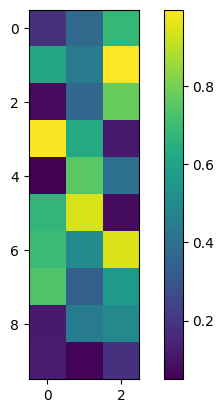

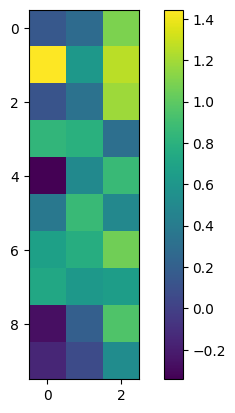

In [8]:
batch_size = 1
seq_len = 10
embedding_dim = 3
x = torch.rand((batch_size, seq_len, embedding_dim)).to(device)
dl = DecoderLayer(embedding_dim, nb_heads=1, dropout=0.1).to(device)
mask = unidirectional_mask(seq_len=seq_len).to(device)
dlo = dl(x, mask=mask)

plt.imshow(x[0].cpu().detach())
plt.colorbar()
plt.show()

plt.imshow(dlo[0].cpu().detach())
plt.colorbar()
plt.show()

## Decoder transformer

Architecture used by GPT-*, Gopher, where it want to predict the next token given previous ones. Uses a mask to make attention causal.

In [9]:
# | export


class DecoderTransformer(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        max_seq_len: int,
        model_size: int,
        nb_heads: int = 1,
        nb_layers: int = 1,
        dropout: float = 0.0,
        bias: bool = True,
    ) -> None:
        super().__init__()
        self.max_seq_len = max_seq_len
        self.tok_emb = nn.Embedding(vocab_size, embedding_dim=model_size)
        self.pos_emb = torch.nn.Embedding(max_seq_len, embedding_dim=model_size)

        self.layers = nn.Sequential(
            *[
                DecoderLayer(model_size=model_size, nb_heads=nb_heads, dropout=dropout, bias=bias)
                for i in range(nb_layers)
            ]
        )
        self.layer_norm = LayerNormalization(model_size)
        self.unembedding = nn.Linear(model_size, vocab_size)

    def get_device(self):
        # Check the device of parameters or buffers
        if next(self.parameters(), None) is not None:
            return next(self.parameters()).device
        elif next(self.buffers(), None) is not None:
            return next(self.buffers()).device
        else:
            return None  # No parameters or buffers in this module

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, L = x.size()
        tok_emb = self.tok_emb(x)
        device = self.get_device()
        pos_emb = self.pos_emb(torch.arange(L, device=device))
        mask = unidirectional_mask(seq_len=L).to(device)
        x = tok_emb + pos_emb
        # x = self.layers(x, mask)
        for layer in self.layers:
            x = layer(x, mask)
        x = self.layer_norm(x)
        logits = self.unembedding(x)
        return logits

    def generate(self, x: torch.Tensor, max_new_tokens: int):
        with torch.no_grad():
            for i in range(max_new_tokens):
                # we take at most max_seq_len tokens
                x_block = x[:, -self.max_seq_len :]
                logits = self(x_block)
                # we take the logit for last token, used to predict token.
                logits = logits[:, -1, :]
                probs = F.softmax(logits, dim=-1)
                tok_next = torch.multinomial(probs, num_samples=1)
                x = torch.cat((x, tok_next), dim=1)
        return x

In [10]:
def print_model_size(model: nn.Module):
    ic(sum(p.numel() for p in model.parameters()) / 1e6, "M parameters")


model = DecoderTransformer(vocab_size=6, max_seq_len=5, model_size=10, nb_heads=1).to(device)
print_model_size(model)
x = torch.tensor([[0, 1, 2, 3, 4], [1, 2, 3, 4, 5]], dtype=torch.int, device=device)
y_hat = model(x)
ic(y_hat.shape)
model.generate(torch.tensor([[0, 1]], dtype=torch.long, device=device), max_new_tokens=5)

ic| sum(p.numel() for p in model.parameters()) / 1e6: 0.001526
    "M parameters": 'M parameters'
ic| y_hat.shape: torch.Size([2, 5, 6])


tensor([[0, 1, 0, 0, 5, 4, 1]], device='mps:0')

## Dataset

In [11]:
with open("../dataset/shakespeare.txt") as f:
    text = f.read()


words = text.split(" ")
train_pos = math.ceil(len(words) * 0.8)
train_words = words[:train_pos]
test_words = words[train_pos:]
train_txt = " ".join(train_words[:])
test_txt = " ".join(test_words[:])

## Tokenizer

GPT2 use a byte-level BPE (byte pair encoding) tokenizer. First we train a tokenizer to create a vocabulary and merge file that is required by GPT2.
GPT-2 expects:
- A fixed vocabulary size (e.g., 50,257 tokens).
- Specific special tokens (<|endoftext|>).
- Byte-level encoding to handle all possible text inputs (including non-standard characters).

So GPT2TokenizerFast enrich trained tokenizer

In [12]:
trained_tokenizer = ByteLevelBPETokenizer()
trained_tokenizer.train_from_iterator([train_txt], vocab_size=1000)
tok_dir = "./shakespare_tok"
os.makedirs(tok_dir, exist_ok=True)
trained_tokenizer.save_model(tok_dir)
tokenizer = GPT2TokenizerFast.from_pretrained(tok_dir)
ic(tokenizer)
ic(len(tokenizer.encode(train_txt)) <= len(train_txt))
tokenizer.encode("hello")

ic| tokenizer: GPT2TokenizerFast(name_or_path='./shakespare_tok', vocab_size=1000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
               	1000: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
               }
               )
ic| len(tokenizer.encode(train_txt)) <= len(train_txt): True


[257, 273, 78]

In [13]:
# | export
def get_trained_tokenizer(train_txt: str, vocab_size: int, name: str) -> Tokenizer:
    trained_tokenizer = ByteLevelBPETokenizer()
    trained_tokenizer.train_from_iterator([train_txt], vocab_size=vocab_size)
    tok_dir = f"./{name}_{vocab_size}"
    os.makedirs(tok_dir, exist_ok=True)
    trained_tokenizer.save_model(tok_dir)
    tokenizer = GPT2TokenizerFast.from_pretrained(tok_dir)
    return tokenizer

In [14]:
# | export
class BPEDataset(Dataset):
    def __init__(self, text: str, tokenizer: Tokenizer, seq_len: int = 20, device: str = "cpu"):
        self.device = device
        self.seq_len = seq_len
        self.text = text
        self.tokenizer = tokenizer

        self.encoded = torch.tensor(self.tokenizer.encode(self.text), dtype=torch.long, device=device)

    def __len__(self):
        return len(self.encoded) // self.seq_len

    def __getitem__(self, idx):
        data_len = len(self.encoded)
        i = idx * self.seq_len
        if i >= data_len:
            raise ValueError(f"idx {idx} bigger than data length {data_len}")
        x = self.encoded[i : i + self.seq_len]
        y = self.encoded[i + 1 : i + self.seq_len + 1]
        return x, y

In [15]:
train_ds = BPEDataset(train_txt, tokenizer=tokenizer, seq_len=10, device=device)
train_dl = DataLoader(train_ds, batch_size=5)
assert next(iter(train_dl))[0].size() == (5, 10)

In [57]:
# | export
class EpochTrainer:
    def __init__(
        self,
        # model: nn.Module,
        get_new_model: callable,
        train_dl: DataLoader,
        test_dl: DataLoader,
        model_version: str,
        model_name: str,
        lr: float = 3e-4,
        nb_epochs: int = 100,
        loss_fn=F.cross_entropy,
        do_save_model: bool = True,
        log_interval: int = 50,
        device: str = "cpu",
    ) -> None:
        self.get_new_model_func = get_new_model
        self.loss_fn = loss_fn
        self.train_dl = train_dl
        self.test_dl = test_dl
        self.nb_epochs = nb_epochs
        self.do_save_model = do_save_model
        self.model_name = model_name
        self.model_version = model_version
        self.device = device
        self.writer = None
        self.lr = lr
        self.log_interval = log_interval

    def compute_loss(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        B, T, C = logits.shape
        logits = logits.view(B * T, C)
        targets = targets.view(B * T)
        loss = self.loss_fn(logits, targets)
        return loss

    @torch.no_grad()
    def evaluate(self, model: nn.Module, iter: int) -> None:
        model.eval()
        losses = []
        for x, y in self.test_dl:
            logits = model(x)
            loss = self.compute_loss(logits, y)
            losses.append(loss.item())
        loss_mean = torch.tensor(losses).mean()
        self.writer.add_scalar(f"test loss", loss_mean, iter)
        model.train()

    def train(self, from_epoch: int = 0) -> nn.Module:
        if from_epoch > 0:
            model = load_model(self.model_name, self.model_version, from_epoch)
        else:
            model = self.get_new_model_func()
        self.writer = SummaryWriter(
            f"../runs/{self.model_name}_{self.model_version}/{datetime.now().strftime('%m-%d-%Y_%H:%M:%S')}"
        )
        ex_x, ex_y = next(iter(self.train_dl))
        self.writer.add_graph(model, (ex_x), use_strict_trace=False)
        self.writer.flush()

        if from_epoch > 0:
            epoch_start_nb = from_epoch + 1
        else:
            epoch_start_nb = 0
        i = 0
        nb_epochs_computed = self.nb_epochs - epoch_start_nb
        nb_batches = len(self.train_dl)
        with tqdm(
            total=nb_batches * nb_epochs_computed,
            desc=f"Epoch {nb_epochs_computed} times batch ({len(self.train_dl)})",
            unit="batch",
        ) as pbar:
            model.train()
            optimizer = torch.optim.AdamW(model.parameters(), lr=self.lr)
            for curr_epoch in range(epoch_start_nb, self.nb_epochs):
                for b, (xb, yb) in enumerate(self.train_dl):
                    i = (curr_epoch * nb_batches) + b

                    logits = model(xb)
                    optimizer.zero_grad()
                    loss = self.compute_loss(logits, yb)
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    optimizer.step()

                    self.writer.add_scalar("train loss", loss.item(), i)

                    pbar.update(1)
                    pbar.set_postfix(
                        {
                            "i": i,
                            "epoch": curr_epoch,
                            "batch_nb": b,
                            "train_loss": f"{loss.item():.4f}",
                        }
                    )

                    if i % self.log_interval == 0:
                        self.evaluate(model, i)
                        for name, weight in model.named_parameters():
                            self.writer.add_histogram(name, weight, i)
                            if weight.grad is not None:
                                g = weight.grad
                                self.writer.add_histogram(f"{name}.grad", g, i)
                                g_norm = g.data.norm(2)
                                self.writer.add_histogram(f"{name}.grad_norm", g_norm, i)

                        if self.do_save_model:
                            save_model(model, self.model_name, self.model_version, i)

        # write embeddings:
        tok_embeddings = model.tok_emb.weight
        tok_metadata = [tokenizer.decode([i]) for i in range(tokenizer.vocab_size)]
        self.writer.add_embedding(tok_embeddings, metadata=tok_metadata)
        pos_embeddings = model.pos_emb.weight
        pos_metadata = range(seq_len)
        self.writer.add_embedding(pos_embeddings, metadata=pos_metadata)

        if self.do_save_model:
            save_model(model, self.model_name, self.model_version, curr_epoch)
        return model


torch.manual_seed(42)

batch_size = 64  # how many independent sequences will we process in parallel?
seq_len = 128  # what is the maximum context length for predictions?
vocab_size = 512 + 1
model_size = 384
num_heads = 6
num_layers = 6
dropout = 0.2
nb_epoch = 100
last_epoch_nb = 0
model_name = "gpt2"
model_version = f"t{vocab_size}_0.1"

tokenizer = get_trained_tokenizer(train_txt, vocab_size=vocab_size, name="shakespare_tok")
train_ds = BPEDataset(train_txt, tokenizer=tokenizer, seq_len=seq_len, device=device)
train_dl = DataLoader(train_ds, batch_size=batch_size)
test_ds = BPEDataset(test_txt, tokenizer=tokenizer, seq_len=seq_len, device=device)
test_dl = DataLoader(test_ds, batch_size=batch_size)


tr = EpochTrainer(
    get_new_model=lambda: DecoderTransformer(
        vocab_size=vocab_size,
        max_seq_len=seq_len,
        model_size=model_size,
        nb_heads=num_heads,
        nb_layers=num_layers,
        dropout=dropout,
    ).to(device),
    lr=3e-4,
    train_dl=train_dl,
    test_dl=test_dl,
    loss_fn=F.cross_entropy,
    nb_epochs=nb_epoch,
    do_save_model=True,
    log_interval=100,
    model_name=model_name,
    model_version=model_version,
    device=device,
)
do_train: bool = False
if do_train:
    model = tr.train(from_epoch=last_epoch_nb)
else:
    # after 1100 it overfits.
    model = load_model(model_name=model_name, model_version=model_version, iter=1100)

/Users/jkunz/Projects/transformer_implementations/my_transformer/utils.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(model_path)


In [58]:
def complete_sentence(sent_start: str, nb_tokens: int = 50):
    beg_sent_toks = tokenizer.encode(sent_start)
    ic(tokenizer.decode(beg_sent_toks))
    sent_input = torch.tensor(beg_sent_toks, dtype=torch.int).expand((1, -1)).to(device)
    sent_output = model.generate(sent_input, max_new_tokens=nb_tokens)
    return tokenizer.batch_decode(sent_output)


sents = complete_sentence("Richard: So should you die;", nb_tokens=100)
print(sents[0])

ic| tokenizer.decode(beg_sent_toks): 'Richard: So should you die;'


Richard: So should you die; fool to a father's hear,
She royed obalks, saw-laval,
That do be it for car as well.
AUFOLIO:
As it is my chur me! and I will be but to Engl flam?

We have dear tell him.

EURIong a never


## Explainability
try to implement
https://towardsdatascience.com/deep-dive-into-anthropics-sparse-autoencoders-by-hand-%EF%B8%8F-eebe0ef59709

In [49]:
activation = {}


def get_activation(name):
    def hook(model, input, output):
        activation[name] = output

    return hook


def get_attention_activation(name):
    def hook(model, input, output):
        activation[name + "_output"] = output[0]
        activation[name + "_weight"] = output[1]

    return hook


model = load_model(model_name=model_name, model_version=model_version, iter=1100)

for l, layer in enumerate(model.layers):
    layer.attn.register_forward_hook(get_attention_activation(f"layer_{l}_attn"))

model.unembedding.register_forward_hook(get_activation("unembedding"))

/Users/jkunz/Projects/transformer_implementations/my_transformer/utils.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(model_path)


In [50]:
# complete_sentence("Richard: So should you die;", nb_tokens=1)
model.eval()
beg_sent_toks = tokenizer.encode("Richard: So should you ever not")
sent_input = torch.tensor(beg_sent_toks, dtype=torch.int).expand((1, -1)).to(device)
sent_output = model.generate(sent_input, max_new_tokens=1)

In [51]:
# activation["layer_0"][0].shape, activation["layer_0"][1].shape
l0_attn_out = activation.get("layer_0_attn_output")
l0_attn_weight = activation.get("layer_0_attn_weight")
# Nb: in a multihead attention, at the end the attention output and weight, is either concatenated or summed along the head dimension (which is removed.)

In [52]:
def display_matrix(t: torch.Tensor) -> None:
    plt.imshow(t.cpu(), aspect="auto")

    plt.colorbar()
    plt.show()

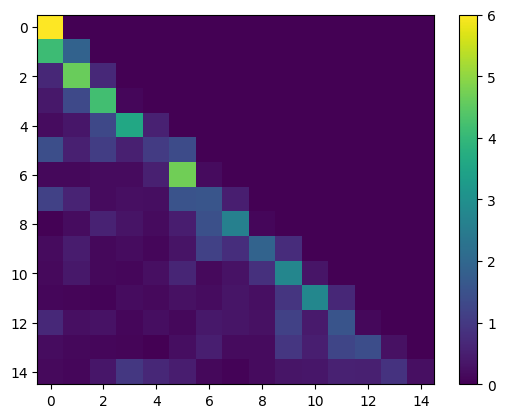

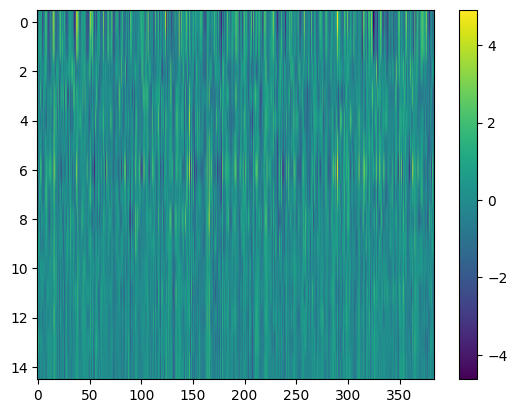

In [53]:
display_matrix(activation.get("layer_0_attn_weight")[0])
display_matrix(activation.get("layer_0_attn_output")[0])

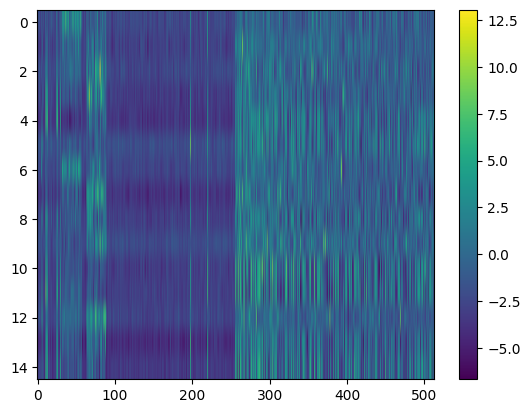

torch.Size([1, 15, 513])

In [54]:
display_matrix(activation.get("unembedding")[0])
activation.get("unembedding").shape

### Generate projector embeddings

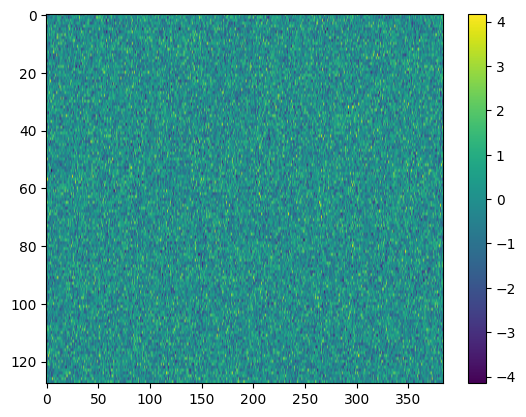

In [55]:
display_matrix(model.pos_emb.weight.detach())

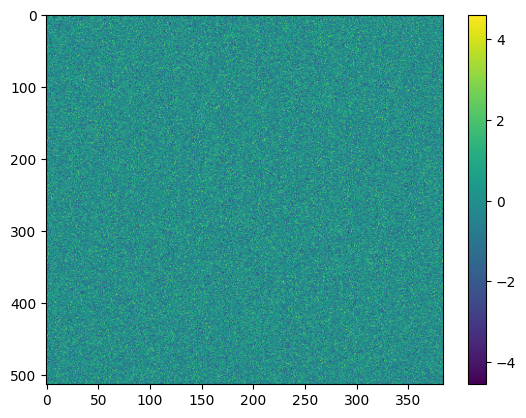

In [56]:
display_matrix(model.tok_emb.weight.detach())